In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

# 一、讀取資料

In [2]:
random.seed(10)
p = 0.1  # 因原始資料筆數太大，隨機抽樣10%資料訓練
df_train = pd.read_csv(
         'train.csv', 
         skiprows=lambda i: i>0 and random.random() > p
)

In [3]:
df_test = pd.read_csv('test.csv')

# 二、探索性資料分析(EDA)

## 檢查訓練資料的標籤分布

In [4]:
len(df_train[df_train['click']==1]) / len(df_train)

0.16968149660230575

In [5]:
#因正項樣本僅17%有unbalanced現象，故oversample正項樣本以提高佔比
df_train = pd.concat([df_train, df_train[df_train['click']==1]], axis=0)

In [6]:
#調整後的正項樣本佔比
len(df_train[df_train['click']==1]) / len(df_train)

0.2901328217898583

In [7]:
#先把測試資料中的標籤欄位拆開，以利後續EDA和特徵工程
Y = df_train['click']
df_train = df_train.drop(axis = 1, columns = ['click'])

## 初步檢查資料的筆數、類別數、缺失值數、資料類型

In [8]:
def check_df(df):
    check_df = []
    for (colname,colval) in df.iteritems():
        exp = df[colname][0]
        cnt = len(colval)
        dnt_cnt = len(df[colname].unique())
        null_cnt = df[colname].isna().sum()
        dtype = df[colname].dtypes
        check_df.append((colname, exp, cnt, dnt_cnt, null_cnt, dtype))
    check = pd.DataFrame(data=check_df, columns=['colname', 'example', 'count', 'distinct_count', 'null_count', 'dtype'])
    return check
        

In [9]:
check_df(df_train)

,colname,example,count,distinct_count,null_count,dtype
0,id,10002044883120869786,4731302,4044949,0,uint64
1,hour,14102100,4731302,240,0,int64
2,C1,1005,4731302,7,0,int64
3,banner_pos,0,4731302,7,0,int64
4,site_id,d6137915,4731302,3472,0,object
5,site_domain,bb1ef334,4731302,4290,0,object
6,site_category,f028772b,4731302,24,0,object
7,app_id,ecad2386,4731302,4829,0,object
8,app_domain,7801e8d9,4731302,307,0,object
9,app_category,07d7df22,4731302,27,0,object


In [10]:
check_df(df_test)

,colname,example,count,distinct_count,null_count,dtype
0,id,1.00002e+19,4577464,4577464,0,float64
1,hour,14103100,4577464,24,0,int64
2,C1,1005,4577464,7,0,int64
3,banner_pos,0,4577464,6,0,int64
4,site_id,235ba823,4577464,2825,0,object
5,site_domain,f6ebf28e,4577464,3366,0,object
6,site_category,f028772b,4577464,22,0,object
7,app_id,ecad2386,4577464,3952,0,object
8,app_domain,7801e8d9,4577464,201,0,object
9,app_category,07d7df22,4577464,28,0,object


### 從初步探索結果，可以發現有的欄位類別很多；考量運算效能，訓練資料總類別50類以上的欄位將先移除不加入訓練
#### 另外device_ip應可轉為經緯度做成GIS變數，惟從探索結果中看起來是加密後的資料，故也無法應用

# 三、變數篩選與特徵工程

## 處理時間特徵

In [11]:
import time
import datetime

In [12]:
def get_datetime(df):
    df['timestamp'] = str("20") + df['hour'].astype(str)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y%m%d%H")
    df['weekday'] = df['timestamp']. dt.weekday
    df['period'] = df['timestamp']. dt.hour
    df = df.drop(axis = 1, columns = ['timestamp', 'hour'])
    return df

In [13]:
df_train = get_datetime(df_train)

In [14]:
df_test = get_datetime(df_test)

## 移除類別過多的特徵

In [15]:
def drop_columns(df, threshold):
    col_list = []
    for (colname,colval) in df.iteritems():
        dnt_cnt = len(df[colname].unique())
        col_list.append((colname, dnt_cnt))
    df_col = pd.DataFrame(col_list, columns=['colname', 'dnt_cnt'])
    columns = df_col[df_col['dnt_cnt']<= threshold]['colname']
    return columns

In [16]:
df_train = df_train[drop_columns(df_train, threshold=50)]

In [17]:
df_test = df_test[drop_columns(df_train, threshold=50)]

In [18]:
check_df(df_train)

,colname,example,count,distinct_count,null_count,dtype
0,C1,1005,4731302,7,0,int64
1,banner_pos,0,4731302,7,0,int64
2,site_category,f028772b,4731302,24,0,object
3,app_category,07d7df22,4731302,27,0,object
4,device_type,1,4731302,5,0,int64
5,device_conn_type,0,4731302,4,0,int64
6,C15,320,4731302,8,0,int64
7,C16,50,4731302,9,0,int64
8,C18,0,4731302,4,0,int64
9,weekday,1,4731302,7,0,int64


In [19]:
check_df(df_test)

,colname,example,count,distinct_count,null_count,dtype
0,C1,1005,4577464,7,0,int64
1,banner_pos,0,4577464,6,0,int64
2,site_category,f028772b,4577464,22,0,object
3,app_category,07d7df22,4577464,28,0,object
4,device_type,1,4577464,4,0,int64
5,device_conn_type,0,4577464,4,0,int64
6,C15,320,4577464,8,0,int64
7,C16,50,4577464,9,0,int64
8,C18,3,4577464,4,0,int64
9,weekday,4,4577464,1,0,int64


## 依Kaggle官方欄位說明，所有變數都是類別變數，故將整個df轉為string以便後續取dummies

In [20]:
df_train = df_train.astype(str)

In [21]:
df_test = df_test.astype(str)

In [22]:
#預覽整理後的資料
df_train.head()

,C1,banner_pos,site_category,app_category,device_type,device_conn_type,C15,C16,C18,weekday,period
0,1005,0,f028772b,07d7df22,1,0,320,50,0,1,0
1,1005,0,50e219e0,0f2161f8,1,0,320,50,3,1,0
2,1005,0,3e814130,07d7df22,1,0,320,50,0,1,0
3,1005,0,50e219e0,f95efa07,1,0,320,50,0,1,0
4,1010,1,50e219e0,0f2161f8,4,0,320,50,3,1,0


In [23]:
df_test.head()

,C1,banner_pos,site_category,app_category,device_type,device_conn_type,C15,C16,C18,weekday,period
0,1005,0,f028772b,07d7df22,1,0,320,50,3,4,0
1,1005,0,28905ebd,07d7df22,1,0,320,50,0,4,0
2,1005,0,28905ebd,07d7df22,1,0,320,50,0,4,0
3,1005,0,50e219e0,0f2161f8,1,0,320,50,3,4,0
4,1005,0,50e219e0,f95efa07,1,0,320,50,0,4,0


## 將test_set和train_set合在一起取dummy

In [24]:
def get_dummies(df1, df2):
    df1_cnt = len(df1)
    df = pd.concat([df1, df2], axis=0)
    df = pd.get_dummies(df)
    df1 = df.iloc[ :df1_cnt]
    df2 = df.iloc[df1_cnt: ]
    return df1, df2

In [25]:
df_train, df_test = get_dummies(df_train, df_test)

In [26]:
check_df(df_train)

,colname,example,count,distinct_count,null_count,dtype
0,C1_1001,0,4731302,2,0,uint8
1,C1_1002,0,4731302,2,0,uint8
2,C1_1005,1,4731302,2,0,uint8
3,C1_1007,0,4731302,2,0,uint8
4,C1_1008,0,4731302,2,0,uint8
...,...,...,...,...,...,...
126,period_5,0,4731302,2,0,uint8
127,period_6,0,4731302,2,0,uint8
128,period_7,0,4731302,2,0,uint8
129,period_8,0,4731302,2,0,uint8


# 四、模型訓練

## train_set, cv_set切割

In [27]:
from sklearn.model_selection import train_test_split
x_train, x_cv, y_train, y_cv = train_test_split(df_train, Y, random_state=1, test_size=0.3)

## 設定模型衡量指標

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

In [29]:
def model_eval(y_cv, y_pred):
    accuracy = accuracy_score(y_cv, y_pred)
    precision = precision_score(y_cv, y_pred)
    recall = recall_score(y_cv, y_pred)
    auc = roc_auc_score(y_cv, y_pred)
    print("Accuracy:" ,accuracy, " Precision:", precision, " Recall:", recall ," auc:", auc )
    mat_con = (confusion_matrix(y_cv, y_pred, labels=[0, 1]))
    fig, px = plt.subplots(figsize=(7.5, 7.5))
    px.matshow(mat_con, cmap=plt.cm.YlOrRd, alpha=0.5)
    for m in range(mat_con.shape[0]):
        for n in range(mat_con.shape[1]):
            px.text(x=m,y=n,s=mat_con[m, n], va='center', ha='center', size='xx-large')
    plt.xlabel('Predictions', fontsize=16)
    plt.ylabel('Actuals', fontsize=16)
    plt.title('Confusion Matrix', fontsize=15)
    plt.show()

## 模型一：使用XGBoost訓練

In [30]:
from xgboost import XGBClassifier

### Base Model

In [31]:
model = XGBClassifier(max_depth = 3)
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:
y_pred_xgb = model.predict(x_cv)

Accuracy: 0.7241908677735733  Precision: 0.6373014374713449  Recall: 0.11475433718996224  auc: 0.5440293909252767


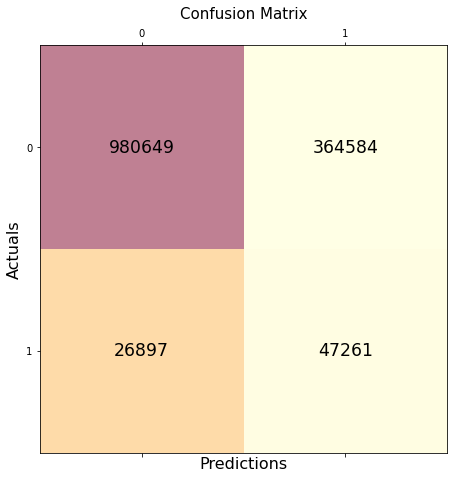

In [33]:
model_eval(y_cv, y_pred_xgb)

### 調參：增加max_depth

In [40]:
model = XGBClassifier(max_depth = 5)
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [41]:
y_pred_xgb = model.predict(x_cv)

Accuracy: 0.7247143317098671  Precision: 0.6348914196607743  Recall: 0.1206084813461375  auc: 0.5461287092333131


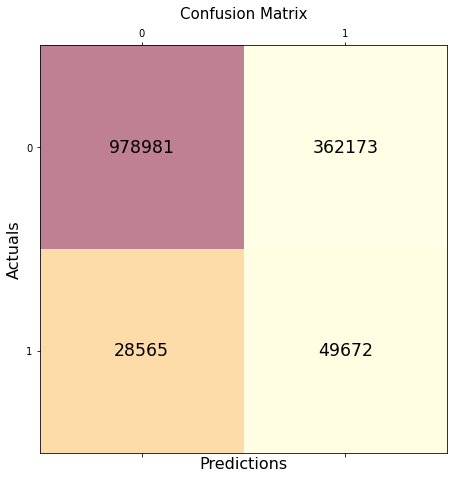

In [42]:
model_eval(y_cv, y_pred_xgb)

In [45]:
#特徵重要性
import shap

In [47]:
explainer = shap.TreeExplainer(model)

In [50]:
shap_values = explainer.shap_values(x_train)

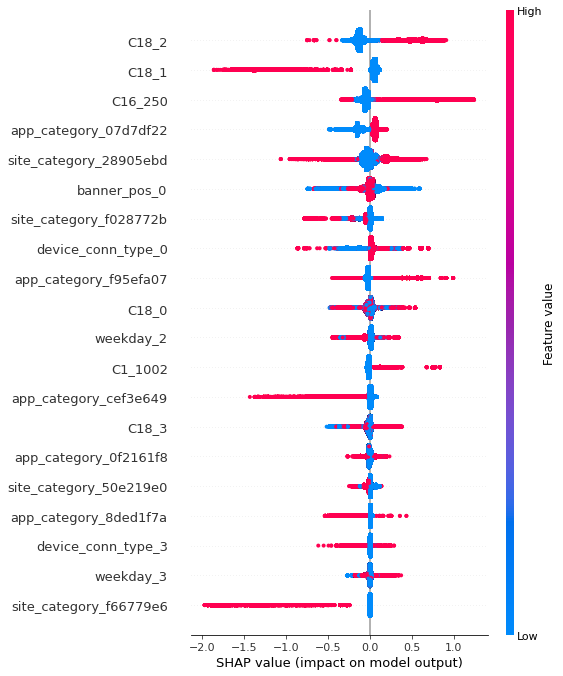

In [51]:
shap.summary_plot(shap_values, x_train)

In [79]:
#採用SHAP值前20名變數給神經網路訓練
x_train_shap = x_train[['C18_2', 'C18_1', 'C16_250', 'app_category_07d7df22', 'site_category_28905ebd', 'banner_pos_0', 'site_category_f028772b', 'device_conn_type_0', 'app_category_f95efa07', 'C18_0', 'weekday_2', 'C1_1002', 'app_category_cef3e649', 'C18_3', 'app_category_0f2161f8', 'site_category_50e219e0', 'app_category_8ded1f7a', 'device_conn_type_3', 'weekday_3', 'site_category_f66779e6']]
x_cv_shap = x_cv[['C18_2', 'C18_1', 'C16_250', 'app_category_07d7df22', 'site_category_28905ebd', 'banner_pos_0', 'site_category_f028772b', 'device_conn_type_0', 'app_category_f95efa07', 'C18_0', 'weekday_2', 'C1_1002', 'app_category_cef3e649', 'C18_3', 'app_category_0f2161f8', 'site_category_50e219e0', 'app_category_8ded1f7a', 'device_conn_type_3', 'weekday_3', 'site_category_f66779e6']]
df_test_shap = df_test[['C18_2', 'C18_1', 'C16_250', 'app_category_07d7df22', 'site_category_28905ebd', 'banner_pos_0', 'site_category_f028772b', 'device_conn_type_0', 'app_category_f95efa07', 'C18_0', 'weekday_2', 'C1_1002', 'app_category_cef3e649', 'C18_3', 'app_category_0f2161f8', 'site_category_50e219e0', 'app_category_8ded1f7a', 'device_conn_type_3', 'weekday_3', 'site_category_f66779e6']]

## 模型二：使用neural networks訓練(shap值篩選變數)

In [66]:
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Activation

### Base Model

In [67]:
def nn_model(input_shape):
    input_var = Input(shape = input_shape, dtype = 'int32')
    X = Dense(units = 8, activation = 'relu')(input_var)
    X = Dense(units = 4, activation = 'relu')(X)
    X = Dense(units = 2)(X)
    X = Activation('softmax')(X)    

    nn_model = Model(inputs=input_var, outputs=X)
    
    return nn_model

In [68]:
input_var = len(check_df(x_train_shap))

In [69]:
nn_model = nn_model((input_var,))
nn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense (Dense)               (None, 8)                 168       
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dense_2 (Dense)             (None, 2)                 10        
                                                                 
 activation (Activation)     (None, 2)                 0         
                                                                 
Total params: 214
Trainable params: 214
Non-trainable params: 0
_________________________________________________________________


In [70]:
opt = keras.optimizers.Adam(learning_rate=0.001)
nn_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

In [71]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y-1]
    return Y

In [72]:
y_oh = convert_to_one_hot(y_train, 2)

In [73]:
nn_model.fit(x_train_shap, y_oh, epochs = 10, batch_size = 10000, shuffle=True)

Epoch 1/10
332/332 [==============================] - 2s 3ms/step - loss: 0.5931 - accuracy: 0.7070 - auc: 0.7511
Epoch 2/10
332/332 [==============================] - 1s 3ms/step - loss: 0.5692 - accuracy: 0.7099 - auc: 0.7733
Epoch 3/10
332/332 [==============================] - 1s 3ms/step - loss: 0.5667 - accuracy: 0.7117 - auc: 0.7755
Epoch 4/10
332/332 [==============================] - 1s 3ms/step - loss: 0.5655 - accuracy: 0.7201 - auc: 0.7773
Epoch 5/10
332/332 [==============================] - 1s 3ms/step - loss: 0.5647 - accuracy: 0.7222 - auc: 0.7781
Epoch 6/10
332/332 [==============================] - 1s 3ms/step - loss: 0.5640 - accuracy: 0.7223 - auc: 0.7788
Epoch 7/10
332/332 [==============================] - 1s 3ms/step - loss: 0.5634 - accuracy: 0.7222 - auc: 0.7793
Epoch 8/10
332/332 [==============================] - 1s 3ms/step - loss: 0.5629 - accuracy: 0.7222 - auc: 0.7797
Epoch 9/10
332/332 [==============================] - 1s 3ms/step - loss: 0.5626 - accur

In [75]:
y_pred_nn = nn_model.predict(x_cv_shap)

44356/44356 [==============================] - 33s 737us/step


In [76]:
y_pred_nn = pd.DataFrame(y_pred_nn).drop(1, axis=1)

In [77]:
y_pred_nn = y_pred_nn.round(0).astype(int)

Accuracy: 0.7222942797298277  Precision: 0.6217314633675916  Recall: 0.10957763236168946  auc: 0.5411631355667587


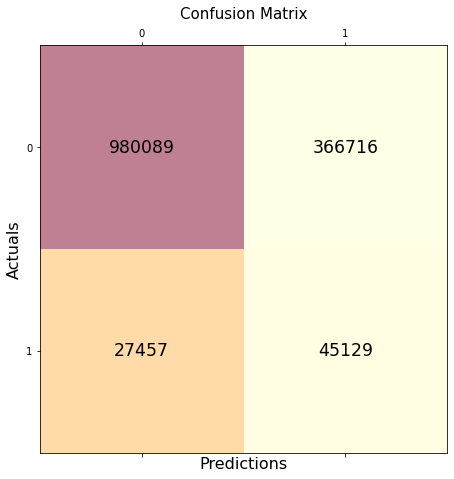

In [78]:
model_eval(y_cv, y_pred_nn)

### 調參：增加dropout層

In [88]:
def nn_model2(input_shape):
    input_var = Input(shape = input_shape, dtype = 'int32')
    X = Dense(units = 8, activation = 'relu')(input_var)
    X = Dropout(rate = 0.2)(X)
    X = Dense(units = 4, activation = 'relu')(X)
    X = Dropout(rate = 0.2)(X)
    X = Dense(units = 2)(X)
    X = Activation('softmax')(X)     

    nn_model = Model(inputs=input_var, outputs=X)
    
    return nn_model

In [89]:
nn_model2 = nn_model2((input_var,))
nn_model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20)]              0         
                                                                 
 dense_3 (Dense)             (None, 8)                 168       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 4)                 36        
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_5 (Dense)             (None, 2)                 10        
                                                                 
 activation_1 (Activation)   (None, 2)                 0   

In [90]:
opt = keras.optimizers.Adam(learning_rate=0.001)
nn_model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

In [91]:
nn_model2.fit(x_train_shap, y_oh, epochs = 10, batch_size = 10000, shuffle=True)

Epoch 1/10
332/332 [==============================] - 2s 5ms/step - loss: 0.6490 - accuracy: 0.6644 - auc: 0.6924
Epoch 2/10
332/332 [==============================] - 2s 5ms/step - loss: 0.5920 - accuracy: 0.7170 - auc: 0.7518
Epoch 3/10
332/332 [==============================] - 2s 5ms/step - loss: 0.5837 - accuracy: 0.7173 - auc: 0.7573
Epoch 4/10
332/332 [==============================] - 2s 5ms/step - loss: 0.5789 - accuracy: 0.7181 - auc: 0.7611
Epoch 5/10
332/332 [==============================] - 2s 5ms/step - loss: 0.5746 - accuracy: 0.7189 - auc: 0.7666
Epoch 6/10
332/332 [==============================] - 2s 5ms/step - loss: 0.5720 - accuracy: 0.7196 - auc: 0.7701
Epoch 7/10
332/332 [==============================] - 2s 6ms/step - loss: 0.5709 - accuracy: 0.7197 - auc: 0.7714
Epoch 8/10
332/332 [==============================] - 2s 7ms/step - loss: 0.5705 - accuracy: 0.7198 - auc: 0.7718
Epoch 9/10
332/332 [==============================] - 2s 5ms/step - loss: 0.5702 - accur

In [93]:
y_pred_nn = nn_model2.predict(x_cv_shap)

44356/44356 [==============================] - 34s 774us/step


In [94]:
y_pred_nn = pd.DataFrame(y_pred_nn).drop(1, axis=1)

In [95]:
y_pred_nn = y_pred_nn.round(0).astype(int)

Accuracy: 0.7218553590941467  Precision: 0.6354535776142882  Recall: 0.09710206509730603  auc: 0.5371659444236443


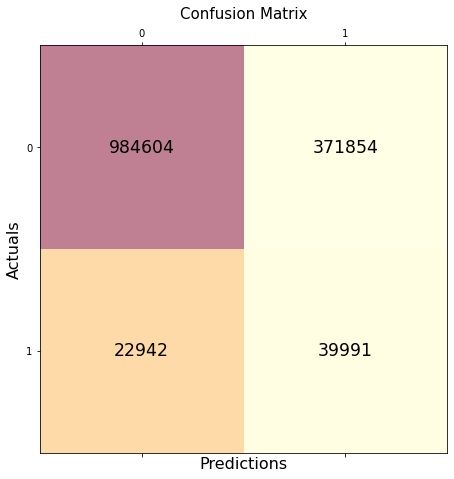

In [96]:
model_eval(y_cv, y_pred_nn)

# 五、提交預測結果

In [97]:
y_submit_nn = nn_model2.predict(df_test_shap)

143046/143046 [==============================] - 113s 788us/step


In [98]:
df_submit_nn = pd.DataFrame(y_submit_nn).drop(1, axis=1)

In [36]:
y_submit = pd.read_csv('sampleSubmission.csv')

In [99]:
y_submit['click'] = df_submit_nn[0]

In [102]:
y_submit.to_csv('y_submit.csv', index=False)

In [101]:
y_submit

,id,click
0,10000174058809263569,0.071182
1,10000182526920855428,0.206604
2,10000554139829213984,0.206604
3,10001094637809798845,0.074965
4,10001377041558670745,0.176820
...,...,...
4577459,9998166651591969718,0.628945
4577460,9998249812366450951,0.072933
4577461,99988023653614546,0.628945
4577462,9999086574712596585,0.002745
